In [378]:
using Flux, Flux.Optimise
using Flux: onehotbatch, onecold, crossentropy, throttle
using MLUtils: mapobs, DataLoader, flatten
using Images: Gray
using CUDA: CuIterator, @cuprint
using ProgressMeter: @showprogress 
using Plots, StatsPlots, StatsBase

In [379]:
#download MNIST Dataset
ENV["DATADEPS_ALWAYS_ACCEPT"] = true
using MLDatasets
train_x, train_y = MNIST.traindata(Float32)
test_x, test_y = MNIST.testdata(Float32)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [380]:
minvocab = Dict(x => digits(x, base = 2, pad = 4) .|> Float32 for x in 0:15)
minvocab[4], minvocab[14] = minvocab[14], minvocab[4]
minvocab

Dict{Int64, Vector{Float32}} with 16 entries:
  5  => [1.0, 0.0, 1.0, 0.0]
  7  => [1.0, 1.0, 1.0, 0.0]
  12 => [0.0, 0.0, 1.0, 1.0]
  8  => [0.0, 0.0, 0.0, 1.0]
  1  => [1.0, 0.0, 0.0, 0.0]
  0  => [0.0, 0.0, 0.0, 0.0]
  4  => [0.0, 1.0, 1.0, 1.0]
  6  => [0.0, 1.0, 1.0, 0.0]
  13 => [1.0, 0.0, 1.0, 1.0]
  2  => [0.0, 1.0, 0.0, 0.0]
  10 => [0.0, 1.0, 0.0, 1.0]
  11 => [1.0, 1.0, 0.0, 1.0]
  9  => [1.0, 0.0, 0.0, 1.0]
  15 => [1.0, 1.0, 1.0, 1.0]
  14 => [0.0, 0.0, 1.0, 0.0]
  3  => [1.0, 1.0, 0.0, 0.0]

In [381]:
invvocab = Dict(v => k for (k, v) in minvocab)

Dict{Vector{Float32}, Int64} with 16 entries:
  [1.0, 1.0, 1.0, 0.0] => 7
  [0.0, 1.0, 0.0, 1.0] => 10
  [0.0, 1.0, 0.0, 0.0] => 2
  [0.0, 1.0, 1.0, 1.0] => 4
  [0.0, 1.0, 1.0, 0.0] => 6
  [1.0, 0.0, 0.0, 1.0] => 9
  [1.0, 0.0, 0.0, 0.0] => 1
  [1.0, 0.0, 1.0, 1.0] => 13
  [1.0, 0.0, 1.0, 0.0] => 5
  [0.0, 0.0, 0.0, 1.0] => 8
  [0.0, 0.0, 0.0, 0.0] => 0
  [1.0, 1.0, 0.0, 1.0] => 11
  [0.0, 0.0, 1.0, 1.0] => 12
  [1.0, 1.0, 0.0, 0.0] => 3
  [0.0, 0.0, 1.0, 0.0] => 14
  [1.0, 1.0, 1.0, 1.0] => 15

In [382]:
rs(w, h) = x -> reshape(x, (w, h))

rs (generic function with 1 method)

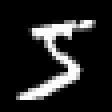

In [383]:
holdouts = sample(1:60000, 1000, replace = false, ordered = true)
training = setdiff(1:60000, holdouts)
mtrainy = map(x -> minvocab[x], train_y[training]) |> collect
mtrainx = train_x[:, :, training] |> flatten |> transpose |> eachrow .|> collect
mtrainx[1] |> rs(28, 28) |> transpose .|> Gray

In [384]:
invvocab[mtrainy[1]]

5

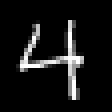

In [385]:
holdouts = sample([1:60000;], 1000, replace = false)
holdouty = map(x -> minvocab[x], train_y[holdouts]) |> collect
holdoutx = train_x[:, :, holdouts] |> flatten |> transpose |> eachrow .|> collect
holdoutx[1] |> rs(28, 28) |> transpose .|> Gray

In [386]:
nn = Chain(Dense(28*28 => (local o = 100), sigmoid), Dense(o => 4, sigmoid)) |> gpu

Chain(
  Dense(784 => 100, σ),                 # 78_500 parameters
  Dense(100 => 4, σ),                   # 404 parameters
)                   # Total: 4 arrays, 78_904 parameters, 576 bytes.

In [387]:
data = DataLoader(mapobs(gpu, (mtrainx, mtrainy)), batchsize = 128, shuffle = true)

DataLoader{MLUtils.MappedData{typeof(gpu), Tuple{Vector{Vector{Float32}}, Vector{Vector{Float32}}}}, Random._GLOBAL_RNG, Val{nothing}}(mapobs(gpu, Tuple{Vector{Vector{Float32}}, Vector{Vector{Float32}}}), 128, false, true, true, false, Val{nothing}(), Random._GLOBAL_RNG())

In [388]:
opt = ADAM(0.001)
params = Flux.params(nn)

Params([Float32[0.08048938 -0.03232238 … 0.07813133 0.05738393; -0.0427351 -0.026833186 … 0.045879558 -0.077074595; … ; -0.02093247 -0.0007707099 … 0.034936674 -0.05322118; -0.055222955 0.08234367 … 0.006280939 -0.035993375], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.01649985 0.013219036 … -0.21240412 0.039903495; 0.03059861 0.10317639 … -0.22722861 0.17487763; -0.07651713 -0.16013809 … 0.23059718 0.028937688; 0.052025594 -0.16899781 … -0.035515122 0.22227865], Float32[0.0, 0.0, 0.0, 0.0]])

In [389]:
Flux.@epochs 5 Flux.train!(loss, params, data, opt)

In [390]:
loss(holdoutx |> gpu, holdouty |> gpu)

113.76287f0

In [401]:
hpred = nn.(holdoutx |> gpu) |> cpu .|> x -> round.(x)
hpreda = map(x -> invvocab[x], hpred) |> collect
hacta = map(x -> invvocab[x], holdouty) |> collect
1 - sum(hpreda .!= hacta) / length(hpreda)

0.906

In [393]:
inds = [i for (i, x) in enumerate(hpreda) if x != hacta[i]]
errorcounts = zip(hpreda[inds], hacta[inds]) |> collect |> countmap
mat = Iterators.product(1:15, 1:15) |> collect 
# .|> x -> x in errorcounts ? errorcounts[x] : 0
mat = mat .|> x -> x in errorcounts.keys ? errorcounts[x] : 0
hcat(hcat(15:-1:1, mat)', 0:15)'

16×16 adjoint(::Matrix{Int64}) with eltype Int64:
 15  0  0  3  0  5  0  1  2  2   0   0   0   0   0   0
 14  0  0  1  1  1  2  0  3  0   0   0   0   0   0   0
 13  0  4  0  0  2  0  4  0  0   0   0   0   0   0   0
 12  0  0  0  0  0  4  0  0  1   0   0   0   0   0   0
 11  0  0  2  0  0  2  0  0  1   0   0   0   0   0   0
 10  0  4  0  2  0  0  1  2  0   0   0   0   0   0   0
  9  0  0  1  0  1  1  0  0  0   0   0   0   0   0   0
  8  0  1  1  0  0  0  0  0  3   0   0   0   0   0   0
  7  0  0  1  2  0  0  1  3  0   0   0   0   0   0   0
  6  0  0  0  1  0  0  0  1  0   0   0   0   0   0   0
  5  0  0  1  0  0  0  0  0  0   0   0   0   0   0   0
  4  0  0  0  2  0  0  0  0  0   0   0   0   0   0   0
  3  0  0  0  1  0  0  1  1  1   0   0   0   0   0   0
  2  0  0  0  0  0  2  0  0  0   0   0   0   0   0   0
  1  0  1  0  2  0  0  0  0  0   0   0   0   0   0   0
  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15

In [394]:
dataTx = (test_x |> flatten)' |> eachrow .|> collect |> gpu
dataTy = [minvocab[y] for y in test_y] .|> collect |> gpu
loss(dataTx, dataTy)

1124.2444f0

In [395]:
something = [invvocab[x] for x in nn.(dataTx) |> cpu .|> x -> round.(x)]

10000-element Vector{Int64}:
 7
 2
 1
 0
 4
 1
 4
 9
 6
 9
 ⋮
 8
 9
 0
 1
 2
 3
 4
 5
 6

In [396]:
1 - (sum(something .!= test_y) / length(test_y))

0.9056

In [397]:
pairs = [(x, test_y[i]) for (i,x) in enumerate(something) if x != test_y[i]]
xn, yn = [k for (k,_) in pairs], [v for (_,v) in pairs]

([6, 6, 3, 13, 7, 3, 0, 15, 8, 10  …  0, 1, 2, 3, 1, 9, 6, 1, 3, 2], [5, 4, 2, 9, 3, 7, 2, 7, 2, 9  …  2, 3, 3, 5, 3, 3, 4, 8, 5, 5])

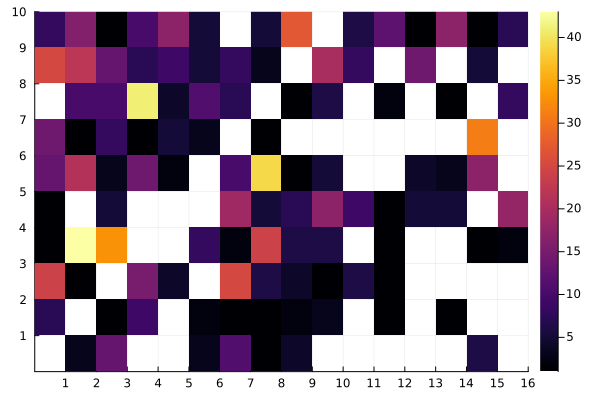

In [398]:
histogram2d(xn, yn, bins = 16, yticks = 1:10, xticks=1:16)

In [399]:
minvocab[7], minvocab[3], minvocab[10], minvocab[14]

(Float32[1.0, 1.0, 1.0, 0.0], Float32[1.0, 1.0, 0.0, 0.0], Float32[0.0, 1.0, 0.0, 1.0], Float32[0.0, 0.0, 1.0, 0.0])